# Ouly TOURE  
# Préparation des données pour la visualisation

Avant d'entamer l'analyse et la visualisation des données de sortie, j'ai préalablement réalisé un traitement complet en Java. Ce traitement a consisté à simuler le centre d'appel VANAD et à générer un fichier de données d'état système, appelé `etat_systeme_sortie.csv`.

Ce fichier contient l’ensemble des variables d’état du système à différents instants, ainsi que les délais d’attente observés, ce qui constitue une base solide pour entraîner des modèles prédictifs et réaliser des analyses statistiques.


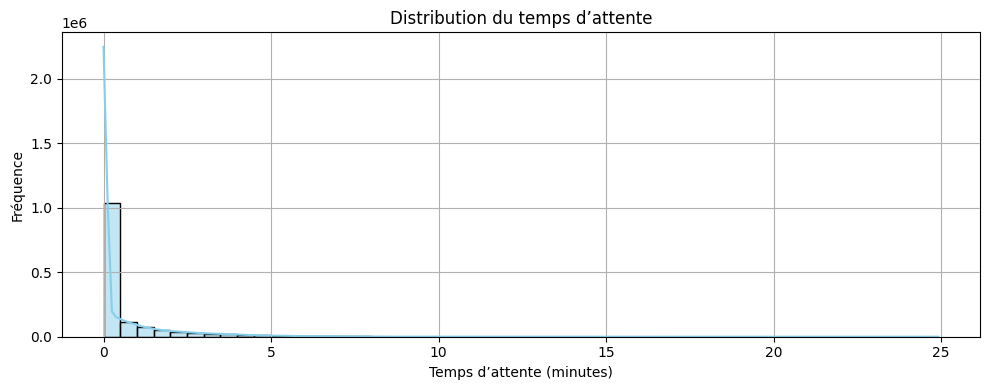

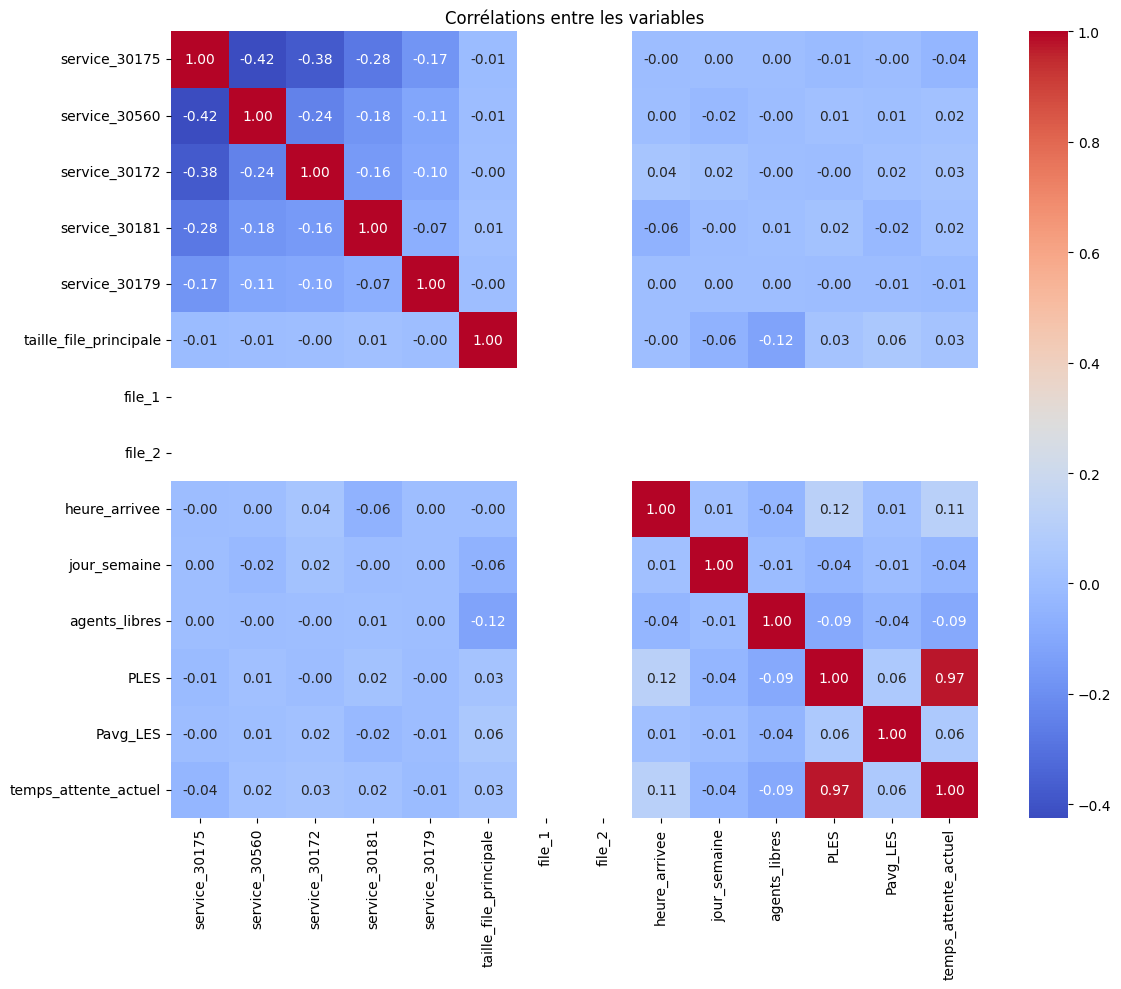

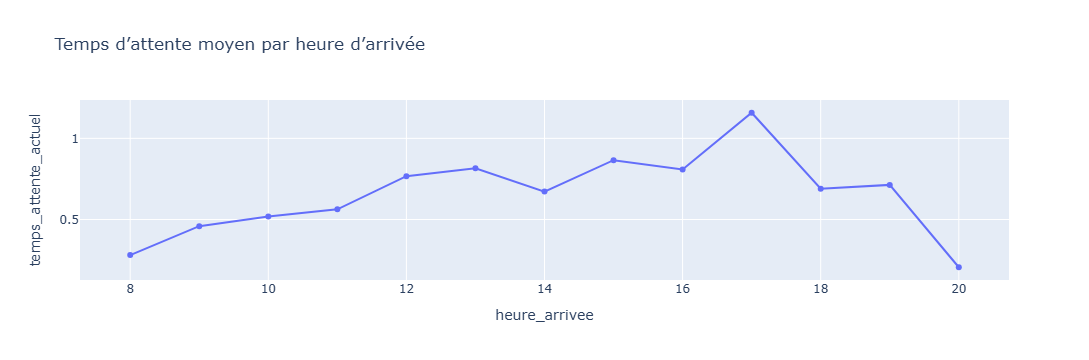

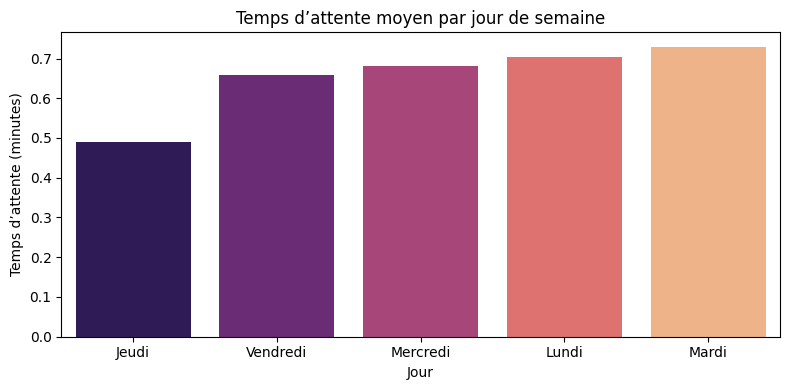

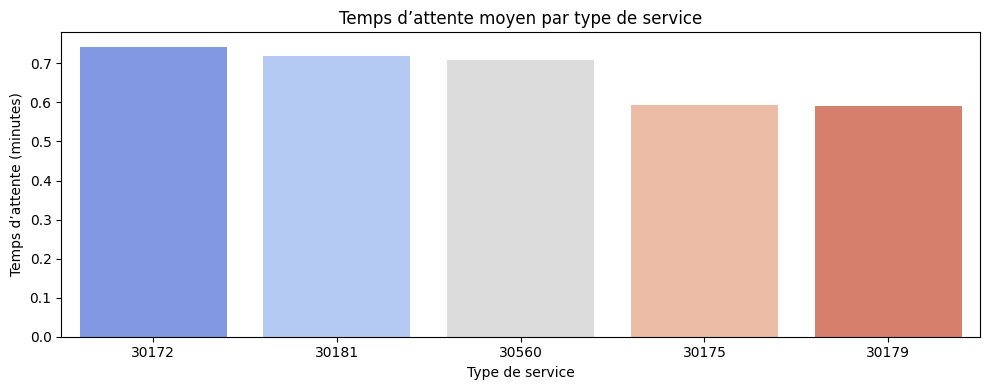

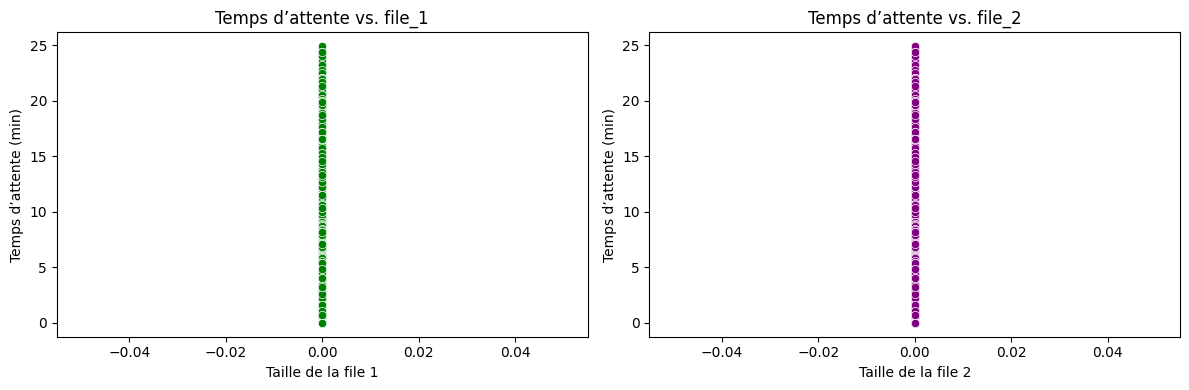

In [1]:
# Visualisation complète du fichier de simulation : etat_systeme_sortie.csv 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Chargement du fichier CSV 
chemin = r"C:\Users\Dell\Desktop\M2_BI_2025\Performance_des_SD\Projet_Perf_Ouly_TOURE_M2_BI_2025\SimulationCentreAppelsVANAD\etat_systeme_sortie.csv"
if not os.path.exists(chemin):
    raise FileNotFoundError(f"Fichier non trouvé : {chemin}")

df = pd.read_csv(chemin)

# Distribution du temps d’attente 
plt.figure(figsize=(10, 4))
sns.histplot(df["temps_attente_actuel"], bins=50, kde=True, color="skyblue")
plt.title("Distribution du temps d’attente")
plt.xlabel("Temps d’attente (minutes)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap des corrélations entre toutes les variables numériques 
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélations entre les variables")
plt.tight_layout()
plt.show()

# Moyenne du temps d’attente par heure d’arrivée 
moyenne_par_heure = df.groupby("heure_arrivee")["temps_attente_actuel"].mean().reset_index()

fig = px.line(
    moyenne_par_heure,
    x="heure_arrivee",
    y="temps_attente_actuel",
    title="Temps d’attente moyen par heure d’arrivée",
    markers=True
)
fig.show()

# Temps d’attente moyen par jour de la semaine 
jours = {
    1: "Lundi", 2: "Mardi", 3: "Mercredi", 4: "Jeudi",
    5: "Vendredi"
        }
df["jour_nom"] = df["jour_semaine"].map(jours)

moyenne_jour = df.groupby("jour_nom")["temps_attente_actuel"].mean().reset_index()
moyenne_jour = moyenne_jour.sort_values(by="temps_attente_actuel")

plt.figure(figsize=(8, 4))
sns.barplot(
    data=moyenne_jour,
    x="jour_nom",
    y="temps_attente_actuel",
    hue="jour_nom",            
    palette="magma",
    dodge=False,
    legend=False
)
plt.title("Temps d’attente moyen par jour de semaine")
plt.ylabel("Temps d’attente (minutes)")
plt.xlabel("Jour")
plt.tight_layout()
plt.show()

# Moyenne du temps d’attente par type de service
colonnes_service = [col for col in df.columns if col.startswith("service_")]
df["service"] = df[colonnes_service].idxmax(axis=1).str.replace("service_", "")

moyenne_service = df.groupby("service")["temps_attente_actuel"].mean().reset_index()
moyenne_service = moyenne_service.sort_values(by="temps_attente_actuel", ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=moyenne_service,
    x="service",
    y="temps_attente_actuel",
    hue="service",        
    palette="coolwarm",
    dodge=False,
    legend=False
)
plt.title("Temps d’attente moyen par type de service")
plt.xlabel("Type de service")
plt.ylabel("Temps d’attente (minutes)")
plt.tight_layout()
plt.show()

# Impact des autres files d’attente sur le temps d’attente (scatterplots)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=df, x="file_1", y="temps_attente_actuel", ax=axes[0], color="green")
axes[0].set_title("Temps d’attente vs. file_1")
axes[0].set_xlabel("Taille de la file 1")
axes[0].set_ylabel("Temps d’attente (min)")

sns.scatterplot(data=df, x="file_2", y="temps_attente_actuel", ax=axes[1], color="purple")
axes[1].set_title("Temps d’attente vs. file_2")
axes[1].set_xlabel("Taille de la file 2")
axes[1].set_ylabel("Temps d’attente (min)")

plt.tight_layout()
plt.show()

In [2]:
# Importation des bibliothèqques nécessaires
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Chargement des données
chemin = r"C:\Users\Dell\Desktop\M2_BI_2025\Performance_des_SD\Projet_Perf_Ouly_TOURE_M2_BI_2025\SimulationCentreAppelsVANAD\etat_systeme_sortie.csv"
if not os.path.exists(chemin):
    raise FileNotFoundError(f"Fichier non trouvé : {chemin}")

df = pd.read_csv(chemin)

# Aperçu du jeu de données
print(df.head())
print(df.info())
print(df.isna().sum())

   service_30175  service_30560  service_30172  service_30181  service_30179  \
0            1.0            0.0            0.0            0.0            0.0   
1            0.0            1.0            0.0            0.0            0.0   
2            0.0            0.0            1.0            0.0            0.0   
3            1.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            1.0            0.0            0.0   

   taille_file_principale  file_1  file_2  heure_arrivee  jour_semaine  \
0                     0.0     0.0     0.0            8.0           4.0   
1                     0.0     0.0     0.0            8.0           4.0   
2                     0.0     0.0     0.0            8.0           4.0   
3                     0.0     0.0     0.0            8.0           4.0   
4                     0.0     0.0     0.0            8.0           4.0   

   agents_libres   PLES  Pavg_LES  temps_attente_actuel  
0            9.0

In [4]:
# Séparation X / y
X = df.drop(columns=["temps_attente_actuel"])
y = df["temps_attente_actuel"]

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Création du modèle ANN 
model = keras.Sequential([
    keras.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Entraînement du modèle
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.3468 - val_loss: 0.0884
Epoch 2/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.1150 - val_loss: 0.0879
Epoch 3/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.1074 - val_loss: 0.0871
Epoch 4/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.1105 - val_loss: 0.0882
Epoch 5/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.1121 - val_loss: 0.0873
Epoch 6/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1088 - val_loss: 0.0871
Epoch 7/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.1093 - val_loss: 0.0868
Epoch 8/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.1084 - val_loss: 0.0852
Epoch 9/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.1098 - val_loss: 0.0844
Epoch 10/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.1100 - val_loss: 0.0870
Epoch 11/100
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.1081 - val_loss: 0.0840
Epoch 12

In [7]:
print(len(history.history["loss"]))

35


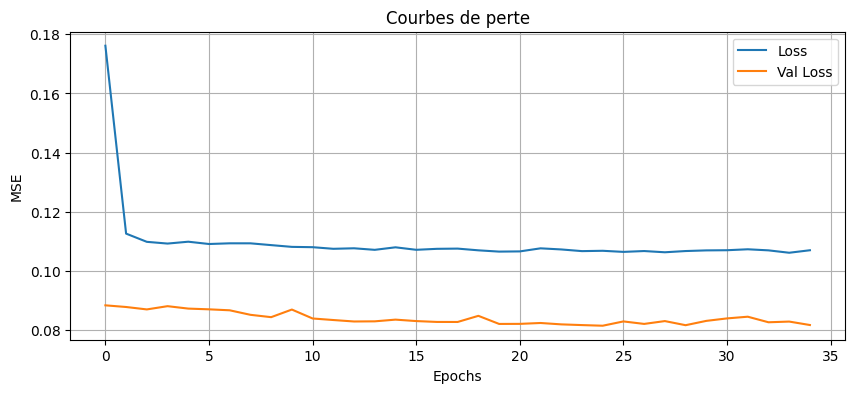

In [8]:
# Courbes de perte
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Courbes de perte")
plt.grid(True)
plt.show()

9018/9018 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
MSE: 0.080
RMSE: 0.283 minutes
RRMSE: 0.429


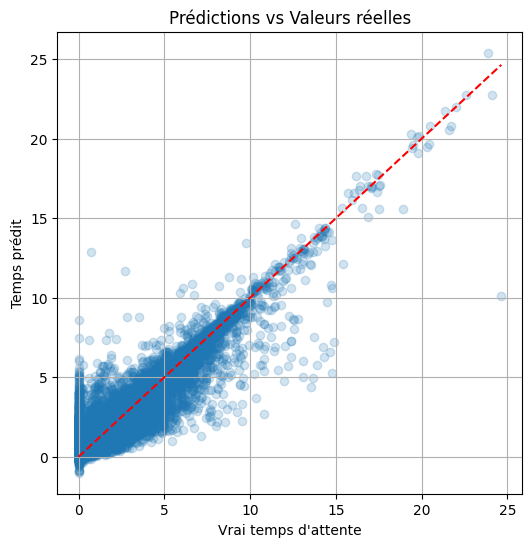

In [9]:
 # Évaluation du modèle
y_pred = model.predict(X_test_scaled).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rrmse = rmse / np.mean(y_test)

print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f} minutes")
print(f"RRMSE: {rrmse:.3f}")

# Prédictions vs valeurs réelles
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.plot([0, max(y_test)], [0, max(y_test)], color="red", linestyle="--")
plt.xlabel("Vrai temps d'attente")
plt.ylabel("Temps prédit")
plt.title("Prédictions vs Valeurs réelles")
plt.grid(True)
plt.show()

In [10]:
# Affichage
print("\nRécapitulatif :")
print(f"Taille du jeu de test : {len(y_test)}")
print(f"Temps d'attente moyen (test) : {np.mean(y_test):.2f} min")
print(f"RMSE final : {rmse:.3f} min")


Récapitulatif :
Taille du jeu de test : 288555
Temps d'attente moyen (test) : 0.66 min
RMSE final : 0.283 min


In [12]:
# Export des prédictions
pred_df = pd.DataFrame({
    "attente_reelle": y_test,
    "prediction_ann": y_pred
})

chemin_export = r"C:\Users\Dell\Desktop\M2_BI_2025\Performance_des_SD\Projet_Perf_Ouly_TOURE_M2_BI_2025\predictions_ann.csv"
pred_df.to_csv(chemin_export, index=False)

print(f"Exportation réussie ! Fichier enregistré à : {chemin_export}")

Exportation réussie ! Fichier enregistré à : C:\Users\Dell\Desktop\M2_BI_2025\Performance_des_SD\Projet_Perf_Ouly_TOURE_M2_BI_2025\predictions_ann.csv


In [1]:
# Performance des prédicteurs LES et Avg-LES
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Charger le fichier complet généré par Java
df = pd.read_csv(r"C:\Users\Dell\Desktop\M2_BI_2025\Performance_des_SD\Projet_Perf_Ouly_TOURE_M2_BI_2025\SimulationCentreAppelsVANAD\etat_systeme_sortie.csv")
# Vrai temps d'attente
y_true = df["temps_attente_actuel"]

# LES
mse_les = mean_squared_error(y_true, df["PLES"])
rmse_les = np.sqrt(mean_squared_error(y_true, df["PLES"]))
rrmse_les = rmse_les / np.mean(y_true)

# Avg-LES
mse_avg_les = mean_squared_error(y_true, df["Pavg_LES"])
rmse_avg_les = np.sqrt(mean_squared_error(y_true, df["Pavg_LES"]))
rrmse_avg_les = rmse_avg_les / np.mean(y_true)

print(f"LES      - MSE : {mse_les:.3f} | RMSE : {rmse_les:.3f} min | RRMSE : {rrmse_les:.3f}")
print(f"Avg-LES  - MSE : {mse_avg_les:.3f} | RMSE : {rmse_avg_les:.3f} min | RRMSE : {rrmse_avg_les:.3f}")

LES      - MSE : 0.094 | RMSE : 0.306 min | RRMSE : 0.465
Avg-LES  - MSE : 1.773 | RMSE : 1.332 min | RRMSE : 2.023
